　　fbprophet是facebook开源的时序数据预测包，提供了简洁的python和R api，可以对时序数据做一些预测，也提供了有些简单的趋势分析。更多细节可以看下[官方文档](https://facebook.github.io/prophet/docs/quick_start.html)。官方doc中给了一个数据集作为prophet的入门，这里我也只是按照官方的入门文档编写了的代码，很简单，只是把数据集换成了北京这8年来的每日温度数据，温度数我从网上爬取的，爬虫源码和数据可以从我[github](https://github.com/xindoo/bjweather)上找到。  

In [1]:
# -*- coding: utf-8 -*-
# 首先导入我们需要的包，fbprophet没多少包依赖，pandas是为了读入数据的，pyplot是用来绘图的，fbprophet也支持直接绘图
import pandas as pd
import matplotlib.pyplot as plt
from fbprophet import Prophet

　　因为爬虫爬到的数据是无序的，所以要重新排序，其实不排序也没关系，并不影响prophet的预测。倒是异常点对预测影响挺多的，异常点太多或者值太大对结果的准确率影响也非常大，如果数据中有异常数据点，可以直接删除掉，prophet有对缺失数据补齐的能力。  

In [3]:
data = pd.read_csv('bjweather.csv')
data = data.sort_values(by=['date'])
data = data.reset_index()

In [4]:
# 对数据做格式转化，prophet所需要的只有两列，分别是ds和y，这里我分别预测未来一个月的最小值和最大值。
dfmin = pd.DataFrame()
dfmin['ds'] = data['date']
dfmin['y'] = data['minT']
dfmax = pd.DataFrame()
dfmax['ds'] = data['date']
dfmax['y'] = data['maxT']
dfmax.head(10)

,ds,y
0,2011-01-01,0
1,2011-01-02,-2
2,2011-01-03,1
3,2011-01-04,-1
4,2011-01-05,-1
5,2011-01-06,0
6,2011-01-07,1
7,2011-01-08,1
8,2011-01-09,-1
9,2011-01-10,-1


　　因为我需要分别预测未来一个月的最低温度和最高温度，所以需要分别训练两个模型，分别是minModel和maxModel。prophet的api也特别简单，只需要把历史数据传给fit函数即可。 

In [5]:
minModel = Prophet()
minModel.fit(dfmin)
maxModel = Prophet()
maxModel.fit(dfmax)

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


　　预测的时候需要传入需要预测的日期，以及预测所用的历史数据日期，prophet提供了一个make_future_dataframe的方法，可以生成所需要的日期数据。periods默认是天，也可以加freq='H'，更改为其他时间粒度，我试了下，貌似最细时间粒度只能到小时。   

In [16]:
futuremin = minModel.make_future_dataframe(periods=60)
futuremax = maxModel.make_future_dataframe(periods=60)
futuremin.tail()

,ds
2978,2019-02-24
2979,2019-02-25
2980,2019-02-26
2981,2019-02-27
2982,2019-02-28


　　用predict方法就可以做成预测了，预测结果里包含'ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
'additive_terms', 'additive_terms_lower', 'additive_terms_upper','weekly', 'weekly_lower', 'weekly_upper', 'yearly', 'yearly_lower','yearly_upper', 'multiplicative_terms', 'multiplicative_terms_lower','multiplicative_terms_upper', 'yhat'，这些数据，具体某个数据的含义大家可以参考下prophet的官方文档，我这里只简单提下部分数据。  

In [17]:
fcmin = minModel.predict(futuremin)
fcmax = maxModel.predict(futuremax)
fcmin[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
# 这几个数据分别是预测日期，预测结果值，预测结果上下界。

,ds,yhat,yhat_lower,yhat_upper
2978,2019-02-24,-3.439225,-6.454288,-0.463849
2979,2019-02-25,-3.239133,-6.475514,-0.422888
2980,2019-02-26,-3.116694,-6.042703,-0.154114
2981,2019-02-27,-2.689156,-6.053885,0.274751
2982,2019-02-28,-2.530241,-5.511546,0.654370


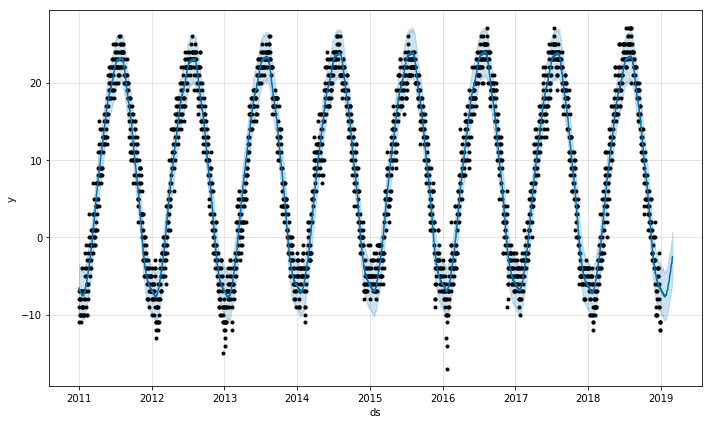

In [18]:
fig0 = minModel.plot(fcmin)

　　除了预测结果和预测的上下界之外，prophet也可以提供一些趋势分析，包括年度趋势，月度趋势，和周趋势。从下面几张图里可以看出，北京在进8年里7-8月最热，1月最冷，大家肯定都知道。但8年里13年最冷，17年最暖和，周三平均温度最高，周一温差最大，周二最冷，这些估计没多少人知道了吧。  

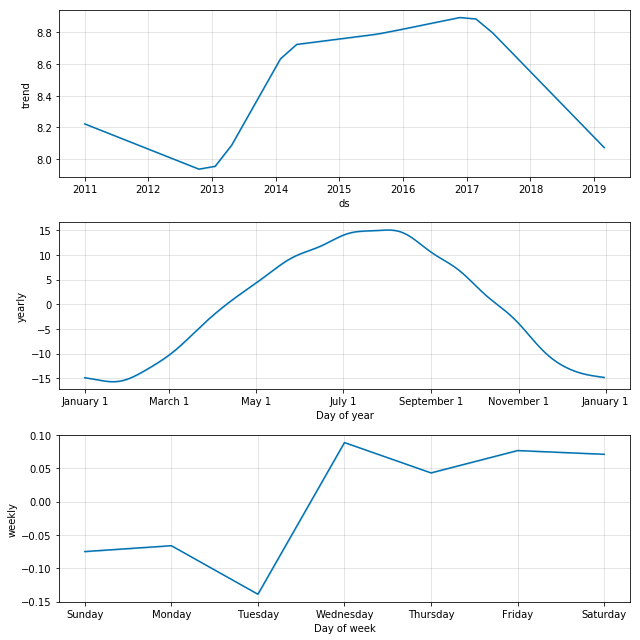

In [13]:
fig3 = minModel.plot_components(fcmin)

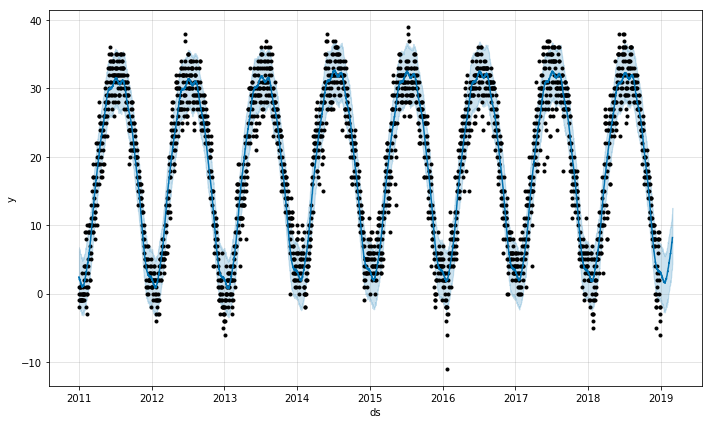

In [19]:
fig1 = maxModel.plot(fcmax)

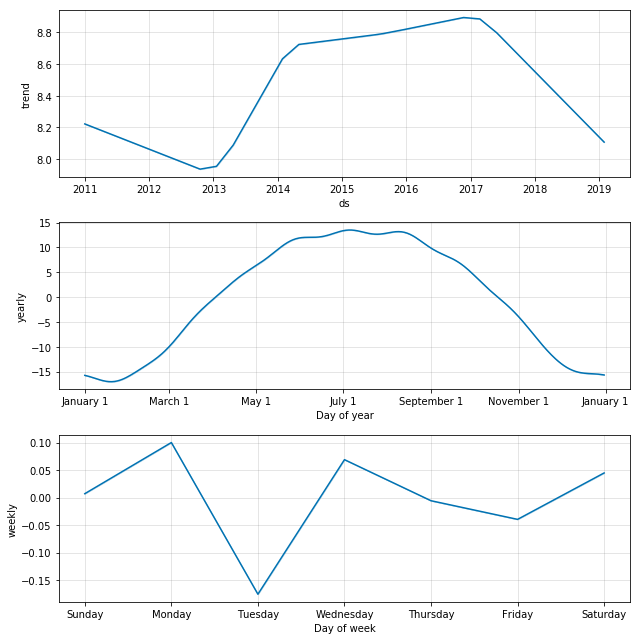

In [11]:
fig2 = maxModel.plot_components(fcmin)

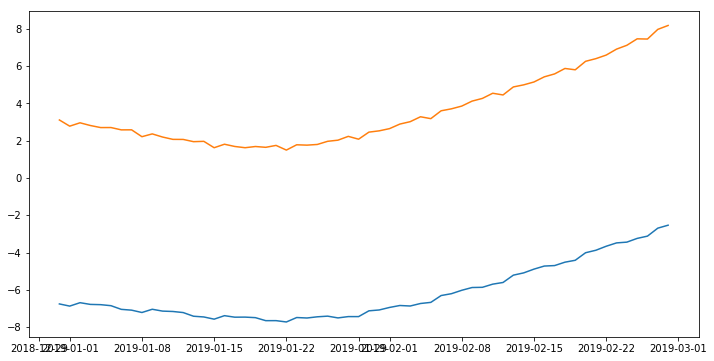

In [25]:
plt.figure(figsize=(12, 6))
plt.plot(fcmin['ds'].tail(60), fcmin['yhat'].tail(60))
plt.plot(fcmax['ds'].tail(60), fcmax['yhat'].tail(60))

In [21]:
fcmin.tail(60)


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
2923,2018-12-31,8.140424,-9.835765,-3.522026,8.140424,8.140424,-14.895672,-14.895672,-14.895672,-0.066108,-0.066108,-0.066108,-14.829564,-14.829564,-14.829564,0.0,0.0,0.0,-6.755248
2924,2019-01-01,8.139293,-9.838228,-3.841323,8.139293,8.139293,-15.011087,-15.011087,-15.011087,-0.138996,-0.138996,-0.138996,-14.872091,-14.872091,-14.872091,0.0,0.0,0.0,-6.871794
2925,2019-01-02,8.138163,-10.038235,-3.581837,8.138163,8.138163,-14.826971,-14.826971,-14.826971,0.088806,0.088806,0.088806,-14.915777,-14.915777,-14.915777,0.0,0.0,0.0,-6.688808
2926,2019-01-03,8.137032,-9.736598,-3.892660,8.137032,8.137032,-14.917603,-14.917603,-14.917603,0.043230,0.043230,0.043230,-14.960833,-14.960833,-14.960833,0.0,0.0,0.0,-6.780571
2927,2019-01-04,8.135902,-9.909186,-3.876419,8.135902,8.135902,-14.930596,-14.930596,-14.930596,0.076789,0.076789,0.076789,-15.007385,-15.007385,-15.007385,0.0,0.0,0.0,-6.794695
2928,2019-01-05,8.134771,-10.038012,-3.796301,8.134771,8.134771,-14.984280,-14.984280,-14.984280,0.071186,0.071186,0.071186,-15.055466,-15.055466,-15.055466,0.0,0.0,0.0,-6.849509
2929,2019-01-06,8.133641,-10.177018,-4.090886,8.133641,8.133641,-15.179916,-15.179916,-15.179916,-0.074907,-0.074907,-0.074907,-15.105010,-15.105010,-15.105010,0.0,0.0,0.0,-7.046276
2930,2019-01-07,8.132510,-9.959429,-4.189611,8.132510,8.132510,-15.221956,-15.221956,-15.221956,-0.066108,-0.066108,-0.066108,-15.155848,-15.155848,-15.155848,0.0,0.0,0.0,-7.089446
2931,2019-01-08,8.131380,-10.199775,-4.256627,8.131380,8.131380,-15.346707,-15.346707,-15.346707,-0.138996,-0.138996,-0.138996,-15.207711,-15.207711,-15.207711,0.0,0.0,0.0,-7.215327
2932,2019-01-09,8.130249,-9.983899,-4.171127,8.130249,8.130249,-15.171418,-15.171418,-15.171418,0.088806,0.088806,0.088806,-15.260224,-15.260224,-15.260224,0.0,0.0,0.0,-7.041169


 　　最后我把预测出的1月份最高温和最低温放在一个图里展示出来，大家看看就好，不必当真。